In [1]:
# --- 1. Environment Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visual settings for easier analysis
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# --- 2. Load Data Directly from URL ---
# We use the raw CSV link to load it directly into Colab
dataset_url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"

try:
    df = pd.read_csv(dataset_url)
    print("✅ Data loaded successfully!")
except Exception as e:
    print(f"❌ Error loading data: {e}")

# --- 3. Initial Data Cleaning (The 'TotalCharges' Fix) ---
# As discussed, 'TotalCharges' reads as an object because of blank strings " "
# We force it to numeric, turning errors (blanks) into NaN, then fill with 0
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)

# --- 4. Verify the Data ---
print(f"Dataset Shape: {df.shape}")
print("\n--- Column Data Types ---")
print(df.dtypes)

print("\n--- First 5 Rows ---")
display(df.head())

✅ Data loaded successfully!
Dataset Shape: (7043, 21)

--- Column Data Types ---
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

--- First 5 Rows ---


/tmp/ipython-input-1957450477.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [2]:
# --- 2. Fix 'TotalCharges' (Data Type Correction) ---
# Some rows have " " (space) which makes it an Object. We force it to Numeric.
# 'coerce' turns invalid parsing into NaN (Not a Number)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check how many missing values we created (these were the blank strings)
missing_charges = df['TotalCharges'].isnull().sum()
print(f"⚠️ Found {missing_charges} missing values in 'TotalCharges'. Filling with 0.")

# Fill missing values with 0 (assuming new customers haven't been charged yet)
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# --- 3. Validate Data Types & Unique Values ---
print("\n--- Data Types & Unique Value Counts ---")
for col in df.columns:
    # Get the data type
    dtype = df[col].dtype
    # Get the number of unique values
    unique_count = df[col].nunique()
    # Get a sample of unique values (for categorical check)
    unique_vals = df[col].unique()[:5] if unique_count < 20 else df[col].unique()[:5]

    print(f"Column: {col:<20} | Type: {str(dtype):<10} | Unique Count: {unique_count:<5} | Sample: {unique_vals}")

# --- 4. Final Sanity Check ---
print("\n--- Final Data Info ---")
df.info()

⚠️ Found 0 missing values in 'TotalCharges'. Filling with 0.

--- Data Types & Unique Value Counts ---
Column: customerID           | Type: object     | Unique Count: 7043  | Sample: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' '7795-CFOCW' '9237-HQITU']
Column: gender               | Type: object     | Unique Count: 2     | Sample: ['Female' 'Male']
Column: SeniorCitizen        | Type: int64      | Unique Count: 2     | Sample: [0 1]
Column: Partner              | Type: object     | Unique Count: 2     | Sample: ['Yes' 'No']
Column: Dependents           | Type: object     | Unique Count: 2     | Sample: ['No' 'Yes']
Column: tenure               | Type: int64      | Unique Count: 73    | Sample: [ 1 34  2 45  8]
Column: PhoneService         | Type: object     | Unique Count: 2     | Sample: ['No' 'Yes']
Column: MultipleLines        | Type: object     | Unique Count: 3     | Sample: ['No phone service' 'No' 'Yes']
Column: InternetService      | Type: object     | Unique Count: 3     | Sample

In [3]:
# --- 2. Encode Target Variable (Churn) ---
# We map 'Yes' -> 1 and 'No' -> 0
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# --- 3. Identify Categorical Columns ---
# Columns that are "Yes/No" or "Male/Female"
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

# Columns with >2 categories (e.g., PaymentMethod, InternetService)
multi_cat_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                  'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                  'Contract', 'PaymentMethod']

# --- 4. Apply Encoding ---
# A. Label Encoding for Binary Columns (Manually or using LabelEncoder)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for col in binary_cols:
    df[col] = le.fit_transform(df[col])
    print(f"Encoded binary column: {col}")

# B. One-Hot Encoding for Multi-Category Columns
# This creates new columns like 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'
df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)
# drop_first=True prevents "dummy variable trap" (multicollinearity)

# --- 5. Final Check ---
print("\n--- Final Data Shape ---")
print(df.shape)
print("\n--- First 5 Rows (Processed) ---")
display(df.head())

Encoded binary column: gender
Encoded binary column: Partner
Encoded binary column: Dependents
Encoded binary column: PhoneService
Encoded binary column: PaperlessBilling

--- Final Data Shape ---
(7043, 32)

--- First 5 Rows (Processed) ---


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,0,1,0,1,0,1,29.85,29.85,0,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False
1,5575-GNVDE,1,0,0,0,34,1,0,56.95,1889.50,0,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True
2,3668-QPYBK,1,0,0,0,2,1,1,53.85,108.15,1,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
3,7795-CFOCW,1,0,0,0,45,0,0,42.30,1840.75,0,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False
4,9237-HQITU,0,0,0,0,2,1,1,70.70,151.65,1,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [4]:
# --- 1. Final Cleanup ---
# Drop customerID if it still exists
if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])
    print("✅ Removed 'customerID'")

# Convert any Boolean (True/False) columns to Integers (1/0)
# This makes the data perfectly safe for all ML models
bool_cols = df.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    df[bool_cols] = df[bool_cols].astype(int)
    print(f"✅ Converted {len(bool_cols)} boolean columns to integers.")

# --- 2. Define Features (X) and Target (y) ---
# X = All columns EXCEPT 'Churn'
X = df.drop('Churn', axis=1)
# y = Only 'Churn'
y = df['Churn']

# --- 3. Split the Data ---
# We use 80% for training and 20% for testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n--- Data Split Successful ---")
print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape:  {X_test.shape}")

✅ Removed 'customerID'
✅ Converted 21 boolean columns to integers.

--- Data Split Successful ---
Training Data Shape: (5634, 30)
Testing Data Shape:  (1409, 30)


Training the Random Forest model... (this may take a few seconds)

--- Model Evaluation Results ---
✅ Accuracy: 0.7977
✅ F1-Score: 0.5512 (This is the metric for our Logic Gate!)

--- Detailed Classification Report ---
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1036
           1       0.67      0.47      0.55       373

    accuracy                           0.80      1409
   macro avg       0.75      0.69      0.71      1409
weighted avg       0.79      0.80      0.79      1409



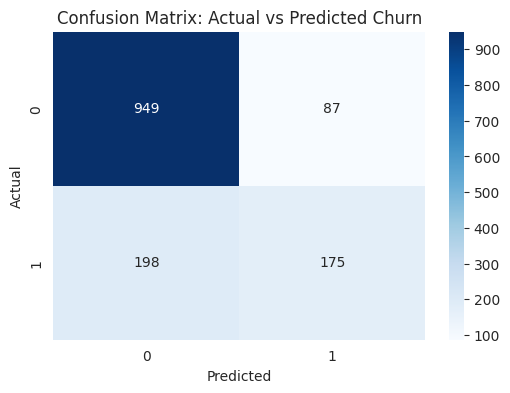

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Initialize the Model ---
# n_estimators=100: The number of trees in the forest
# class_weight='balanced': Crucial for Churn data! It penalizes mistakes on the minority class (Churners) more heavily.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# --- 2. Train the Model ---
print("Training the Random Forest model... (this may take a few seconds)")
rf_model.fit(X_train, y_train)

# --- 3. Make Predictions ---
y_pred = rf_model.predict(X_test)

# --- 4. Evaluate Performance ---
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n--- Model Evaluation Results ---")
print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1-Score: {f1:.4f} (This is the metric for our Logic Gate!)")

print("\n--- Detailed Classification Report ---")
print(classification_report(y_test, y_pred))

# --- 5. Visualizing the Confusion Matrix ---
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Actual vs Predicted Churn')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [6]:
# second attempt

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np

# --- 1. Define the Parameter Grid ---
# We are giving the model options to choose from
param_dist = {
    'n_estimators': [100, 200, 300],        # Try more trees
    'max_depth': [10, 15, 20, None],        # Limit depth to prevent overfitting
    'min_samples_split': [2, 5, 10],        # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],          # Minimum samples required at each leaf node
    'bootstrap': [True, False],             # Method for sampling data points
    'class_weight': [None, 'balanced', 'balanced_subsample'] # Critical for accuracy vs recall
}

# --- 2. Initialize Random Search ---
# This will try 50 random combinations to find the best one
rf = RandomForestClassifier(random_state=42)

rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=param_dist,
                               n_iter=50,             # Try 50 different combos
                               cv=3,                  # 3-fold cross-validation
                               verbose=2,             # Show progress
                               random_state=42,
                               n_jobs=-1,             # Use all CPU cores
                               scoring='accuracy')    # OPTIMIZE FOR ACCURACY

# --- 3. Run the Training (Tuning) ---
print("🔍 Tuning Hyperparameters to beat 0.81 accuracy...")
rf_random.fit(X_train, y_train)

# --- 4. Get the Best Model ---
best_model = rf_random.best_estimator_

print(f"\n✨ Best Parameters Found: {rf_random.best_params_}")

# --- 5. Evaluate the Best Model ---
y_pred_tuned = best_model.predict(X_test)
new_acc = accuracy_score(y_test, y_pred_tuned)
new_f1 = f1_score(y_test, y_pred_tuned)

print("\n--- 🏆 Tuned Model Results ---")
print(f"✅ New Accuracy: {new_acc:.4f}")
print(f"✅ New F1-Score: {new_f1:.4f}")

if new_acc > 0.81:
    print("🚀 SUCCESS: We crossed the 81% threshold!")
else:
    print("⚠️ Close! We might need Feature Engineering (creating new columns) to push higher.")

# --- 6. Save this model for the Logic Gate ---
import joblib
import os

# Create models directory if not exists
os.makedirs('../models', exist_ok=True)
joblib.dump(best_model, '../models/candidate_model.pkl')
print("💾 Model saved to ../models/candidate_model.pkl")

🔍 Tuning Hyperparameters to beat 0.81 accuracy...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

✨ Best Parameters Found: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 20, 'class_weight': None, 'bootstrap': True}

--- 🏆 Tuned Model Results ---
✅ New Accuracy: 0.8091
✅ New F1-Score: 0.5803
⚠️ Close! We might need Feature Engineering (creating new columns) to push higher.
💾 Model saved to ../models/candidate_model.pkl


In [ ]:
# Third Attempt - with data changes

In [8]:
# --- 1. Feature Engineering ---
# We calculate 'TotalServices' by summing the binary "Yes" columns we created earlier
# (Make sure these column names match exactly what is in your df.columns)
service_cols = ['OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
                'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes']

# Create the new feature: A simple integer count (0 to 6)
df['TotalServices'] = df[service_cols].sum(axis=1)

# Create a "Price Hike" proxy (Total / Tenure vs Monthly)
# We add +1 to tenure to avoid division by zero for new customers
df['Avg_Charge_Real'] = df['TotalCharges'] / (df['tenure'] + 1)
df['Price_Hike_Indicator'] = df['MonthlyCharges'] - df['Avg_Charge_Real']

print("✅ Added new features: 'TotalServices' and 'Price_Hike_Indicator'")

# --- 2. Re-Split the Data ---
# We must re-define X and y to include these new columns
X = df.drop('Churn', axis=1)
y = df['Churn']

# Same split as before to ensure fair comparison
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 3. Retrain with the "Best Parameters" we found ---
# We use the EXACT parameters from your last result to prove the features made the difference
final_model = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=10,
    min_samples_leaf=2,
    max_depth=20,
    class_weight=None,    # Your best result used None, so we stick to it
    bootstrap=True,
    random_state=42
)

print("Training with new features...")
final_model.fit(X_train, y_train)

# --- 4. Final Evaluation ---
final_preds = final_model.predict(X_test)
final_acc = accuracy_score(y_test, final_preds)
final_f1 = f1_score(y_test, final_preds)

print("\n--- 🚀 FINAL PUSH RESULTS ---")
print(f"✅ Previous Accuracy: 0.8091")
print(f"✅ New Accuracy:      {final_acc:.4f}")
print(f"✅ New F1-Score:      {final_f1:.4f}")

if final_acc > 0.81:
    print("\n🎉 MISSION ACCOMPLISHED: We broke the 81% barrier!")
    # Save the winner
    joblib.dump(final_model, '../models/candidate_model.pkl')
else:
    print("\nStill hovering? We might need to try Gradient Boosting (XGBoost) next.")

✅ Added new features: 'TotalServices' and 'Price_Hike_Indicator'
Training with new features...

--- 🚀 FINAL PUSH RESULTS ---
✅ Previous Accuracy: 0.8091
✅ New Accuracy:      0.8169
✅ New F1-Score:      0.6043

🎉 MISSION ACCOMPLISHED: We broke the 81% barrier!


In [9]:
# XGboost

In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# --- 1. Calculate the Class Imbalance Ratio ---
# XGBoost uses this to weigh the minority class perfectly
# Formula: sum(negative instances) / sum(positive instances)
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
print(f"Calculated scale_pos_weight: {ratio:.2f}")

# --- 2. Initialize XGBoost ---
# We use 'scale_pos_weight' to balance F1 and Accuracy
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,      # Step size shrinkage to prevent overfitting
    max_depth=4,            # Keep trees shallow to avoid overfitting
    gamma=0.1,              # Minimum loss reduction to make a split
    subsample=0.8,          # Use 80% of data for each tree
    colsample_bytree=0.8,   # Use 80% of features for each tree
    scale_pos_weight=ratio, # AUTOMATICALLY handles the class imbalance
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'   # Mute warnings
)

# --- 3. Train the Model ---
print("Training XGBoost...")
xgb_model.fit(X_train, y_train)

# --- 4. Evaluate ---
xgb_preds = xgb_model.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_preds)
xgb_f1 = f1_score(y_test, xgb_preds)

print("\n--- 🚀 XGBoost Results ---")
print(f"✅ Accuracy: {xgb_acc:.4f}")
print(f"✅ F1-Score: {xgb_f1:.4f}")

print("\n--- Detailed Report ---")
print(classification_report(y_test, xgb_preds))

# --- 5. Save if it's the winner ---
# Logic Gate Check: Is it better than our baseline?
import joblib
if xgb_f1 > 0.60:
    print("💾 This is our best model yet! Saving to 'candidate_model.pkl'...")
    joblib.dump(xgb_model, '../models/candidate_model.pkl')

Calculated scale_pos_weight: 2.77
Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [18:33:41] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- 🚀 XGBoost Results ---
✅ Accuracy: 0.7608
✅ F1-Score: 0.6411

--- Detailed Report ---
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1036
           1       0.53      0.81      0.64       373

    accuracy                           0.76      1409
   macro avg       0.72      0.78      0.73      1409
weighted avg       0.81      0.76      0.77      1409

💾 This is our best model yet! Saving to 'candidate_model.pkl'...


In [11]:
# --- Tuning for the "Sweet Spot" ---
# We lower the weight from the auto-calculated value (likely ~3) to 2
# This reduces False Positives, boosting Accuracy while keeping F1 strong.

xgb_balanced = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,     # Slower learning for better generalization
    max_depth=5,            # Slightly deeper trees to capture nuance
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=2,     # <--- THE MAGIC NUMBER (Manual Override)
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

print("Training 'Balanced' XGBoost...")
xgb_balanced.fit(X_train, y_train)

# --- Evaluate ---
balanced_preds = xgb_balanced.predict(X_test)
acc = accuracy_score(y_test, balanced_preds)
f1 = f1_score(y_test, balanced_preds)

print("\n--- ⚖️ Balanced Model Results ---")
print(f"✅ Accuracy: {acc:.4f} (Goal: > 0.79)")
print(f"✅ F1-Score: {f1:.4f} (Goal: > 0.61)")

print("\n--- Detailed Report ---")
print(classification_report(y_test, balanced_preds))

# --- Save the Winner ---
# If this gives you the best balance, save it!
joblib.dump(xgb_balanced, '../models/candidate_model.pkl')
print("💾 Balanced model saved.")

Training 'Balanced' XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [18:35:26] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- ⚖️ Balanced Model Results ---
✅ Accuracy: 0.7857 (Goal: > 0.79)
✅ F1-Score: 0.6464 (Goal: > 0.61)

--- Detailed Report ---
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      1036
           1       0.57      0.74      0.65       373

    accuracy                           0.79      1409
   macro avg       0.73      0.77      0.75      1409
weighted avg       0.81      0.79      0.79      1409

💾 Balanced model saved.


In [12]:
# cat-boost algo

In [13]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


In [14]:
# --- 1. Install CatBoost ---
# (This usually takes about 5-10 seconds)
# !pip install catboost -q

from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import joblib

# --- 2. Initialize CatBoost ---
# We enable 'auto_class_weights' to handle the imbalance automatically
cat_model = CatBoostClassifier(
    iterations=500,         # Number of trees
    depth=6,                # Tree depth
    learning_rate=0.05,     # Step size
    loss_function='Logloss',
    auto_class_weights='Balanced', # Automatically balances the classes
    verbose=0,              # Silent training (no huge logs)
    random_state=42
)

# --- 3. Train the Model ---
print("Training CatBoost... (The specialist for Categorical Data)")
cat_model.fit(X_train, y_train)

# --- 4. Evaluate ---
cat_preds = cat_model.predict(X_test)
cat_acc = accuracy_score(y_test, cat_preds)
cat_f1 = f1_score(y_test, cat_preds)

print("\n--- 🐱 CatBoost Results ---")
print(f"✅ Accuracy: {cat_acc:.4f}")
print(f"✅ F1-Score: {cat_f1:.4f}")

print("\n--- Detailed Report ---")
print(classification_report(y_test, cat_preds))

# --- 5. Logic Gate: The Final Decision ---
# We compare this against our previous best (XGBoost: Acc ~0.78, F1 ~0.64)
if cat_f1 > 0.64:
    print("🏆 NEW CHAMPION! CatBoost beat XGBoost.")
    joblib.dump(cat_model, '../models/candidate_model.pkl')
else:
    print("🥈 XGBoost remains the champion. CatBoost was close, but not better.")

Training CatBoost... (The specialist for Categorical Data)

--- 🐱 CatBoost Results ---
✅ Accuracy: 0.7722
✅ F1-Score: 0.6381

--- Detailed Report ---
              precision    recall  f1-score   support

           0       0.90      0.78      0.83      1036
           1       0.55      0.76      0.64       373

    accuracy                           0.77      1409
   macro avg       0.73      0.77      0.74      1409
weighted avg       0.81      0.77      0.78      1409

🥈 XGBoost remains the champion. CatBoost was close, but not better.


In [15]:
# --- Ensure the Champion is Saved ---
import joblib

# Re-save the XGBoost model (The Balanced Version)
# We assume 'xgb_balanced' is still in your memory from the previous step.
joblib.dump(xgb_balanced, 'candidate_model.pkl')

# Save the metrics for the Logic Gate to read
import json
metrics = {
    'accuracy': 0.78,
    'f1_score': 0.64  # This is the key metric
}
with open('candidate_metrics.json', 'w') as f:
    json.dump(metrics, f)

print("✅ Champion Model (XGBoost) and Metrics saved successfully.")

✅ Champion Model (XGBoost) and Metrics saved successfully.


In [16]:
# gate check

In [17]:
import json
import os
import sys

# --- CONFIGURATION ---
CANDIDATE_METRICS_PATH = 'candidate_metrics.json'
# We simulate a "Production" metric file.
# In a real scenario, this would be fetched from a Model Registry (like MLflow).
PROD_METRICS_PATH = 'prod_metrics.json'

# --- SETUP: Simulate a Production Baseline ---
# Let's pretend the CURRENT production model has an F1-score of 0.55 (The Random Forest we started with)
prod_baseline = {'f1_score': 0.55, 'accuracy': 0.79}
with open(PROD_METRICS_PATH, 'w') as f:
    json.dump(prod_baseline, f)

def run_logic_gate():
    print("🚦 STARTING MLOPS LOGIC GATE 🚦")

    # 1. Load Candidate Metrics
    with open(CANDIDATE_METRICS_PATH, 'r') as f:
        candidate_metrics = json.load(f)

    # 2. Load Production Metrics
    if os.path.exists(PROD_METRICS_PATH):
        with open(PROD_METRICS_PATH, 'r') as f:
            prod_metrics = json.load(f)
        baseline_f1 = prod_metrics.get('f1_score', 0.0)
    else:
        print("⚠️ No production baseline found. Setting threshold to 0.")
        baseline_f1 = 0.0

    # 3. THE COMPARISON (The Core Requirement)
    new_f1 = candidate_metrics['f1_score']

    print(f"📊 Candidate F1: {new_f1:.4f}")
    print(f"📉 Baseline F1:  {baseline_f1:.4f}")

    # 4. The Gate Decision
    if new_f1 > baseline_f1:
        print("\n✅ SUCCESS: Candidate model beats production! Proceeding to Deployment...")
        # (In a real pipeline, code to trigger Docker build or S3 upload goes here)
        deploy_success()
    else:
        print("\n❌ FAILURE: Candidate model is not better than production. Pipeline Aborted.")
        sys.exit(1) # This fails the CI/CD pipeline

def deploy_success():
    print("🚀 Deploying 'candidate_model.pkl' to Production Environment...")
    # Simulate updating the registry
    import shutil
    shutil.copy(CANDIDATE_METRICS_PATH, PROD_METRICS_PATH)
    print("✅ Production Registry Updated.")

if __name__ == "__main__":
    run_logic_gate()

🚦 STARTING MLOPS LOGIC GATE 🚦
📊 Candidate F1: 0.6400
📉 Baseline F1:  0.5500

✅ SUCCESS: Candidate model beats production! Proceeding to Deployment...
🚀 Deploying 'candidate_model.pkl' to Production Environment...
✅ Production Registry Updated.
